### Why Do you Need Map Reduce?

* CPU executes operations on data stored in RAM

* Data may need to be read from Disk and put into RAM

* What if we can't allocate data in RAM?
  * Data that is 4 GB need way more RAM for the ancillary Information

* Process file in chunks (batches)
  * Load and process once chunk if possible


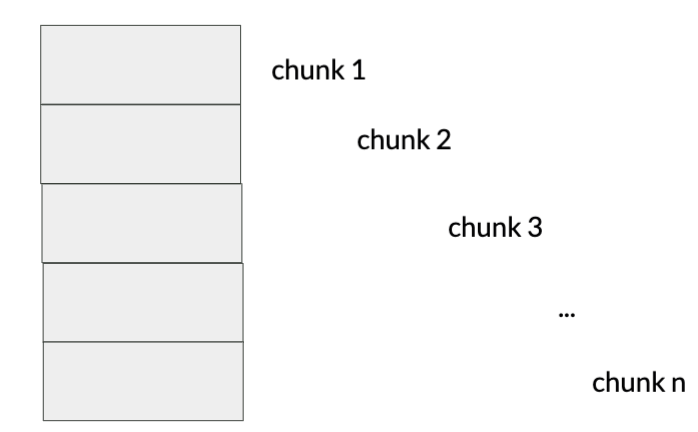

### Issue with batching

* We often talk about CPU cost but often overlook discussing IO cost

* Even if the operation is not CPU-intensive, working with large files can be computationally challenging due to coslty IO

* Typical 7200 RPM HDD will deliver a read/write speed of 80-160MB/s.
   * Costlier drives (15k RPM) or solid state drives can deliver substantially more (avg. 350 MB/S)
* Reading a very large file can take hours 
  * 200 MB/s or ~ 11 GB/Minute or ~ 703 GB/hour (less than 1 TB)
  * Ex. 200 TB file takes more than 200 hours to read.

* Keep in mind that we cannot store the file in RAM, 
  * Therefore, for each operation we need to run on the file, it's necessary to read the complete file



In [4]:
# On Linux
# !head -c 1G </dev/urandom > /tmp/myfile
# BE EXTRA CARFUL WITH THE FOLLOWIN
!dd if=/dev/zero of=/tmp/temp_1GB_file bs=1024 count=1048576


1048576+0 records in
1048576+0 records out
1073741824 bytes transferred in 3.232714 secs (332148704 bytes/sec)


In [5]:
!du -sch /tmp/temp_1GB_file

1.0G	/tmp/temp_1GB_file
1.0G	total


In [6]:
%%timeit

# Running on a solid state drive.
for _ in open("/tmp/temp_1GB_file", "rb").readlines():
  pass


874 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### How Fast are Your Disks? 

* Find out the open source way, with `fio`

https://arstechnica.com/gadgets/2020/02/how-fast-are-your-disks-find-out-the-open-source-way-with-fio/


### Example using HPC Computing 

* Distribute a chunk of the large file across machines
* Each machine processes the data independently
* Paradigm works well with batch-like operations
  * Each machine can independently do the job on a file chunk
  * Results can be combined from each machine 

### HPC Cluster
* Example of a cluster topology [Apollo2](https://docs.hpc.sussex.ac.uk/apollo2/)

![](https://docs.hpc.sussex.ac.uk/apollo2/_images/hpc-diagram.png)




### Using GNU-Parallel to run multiple batches

* ```GNU parallel is a command-line driven utility for Linux and other Unix-like operating systems which allows the user to execute shell scripts or commands in parallel.``` 

* Can run multiple processes on the same machine or split jobs across multiple machines
  * Uses `SSH`

* [GNU-parallel Tutorial at Admin Magazine](https://www.admin-magazine.com/HPC/Articles/GNU-Parallel-Multicore-at-the-Command-Line-with-GNU-Parallel)

* [paralle-ssh](https://www.tecmint.com/run-commands-on-multiple-linux-servers/) package is a simple utility that mimicks Parallel with SSH





### Example of GNU parallel

1. Remove empty lines from the original file

```awk NF text.txt > text_no_empty_line.txt```

2. Split the file into multiple chunks

```split -l 1 text_no_empty_line.txt.txt text_subset_```

3 Use parallel to run each chunk separately
  * The second field is added for illustration purposes

``` 
# without Parallel
# tr -s '[[:punct:][:space:]]' '\n' < text_subset_aa | awk '{print $1"\t1"}' > text_subset_aa.map
# tr -s '[[:punct:][:space:]]' '\n' < text_subset_ab | awk '{print $1"\t1"}' > text_subset_ab.map
# tr -s '[[:punct:][:space:]]' '\n' < text_subset_ac | awk '{print $1"\t1"}' > > text_subset_ac.map
```
```
### With Parallel
ls text_subset* | parallel --dry-run "tr -s '[[:punct:][:space:]]' '\n' < {} | awk '{print \$1\"\t1\"}' > {}.map"
````

```
### With Parallel running on diferent machines using SSH
ls text_subset* | parallel --sshloginfile sshnodes \
     --dry-run \
     --transfer \
     --return {}.map \
     --cleanup \
      "tr -s '[[:punct:][:space:]]' '\n' < {} | awk '{print \$1\"\t1\"}' > {}.map"
````


4. Combine file and sort counts

```cat *.map | sort -k 1 > all_words.map```

5. Merge successive counts

```uniq -c  all_words.map| awk '{print $2, $1} ' > all_words.counts```




### Issues with the Approach
 * Distributed programs are complicated to write
   * For the trivial example above, data must be split, transferred, and results merged 

* Does not offer any redundancy
  * https://computer.howstuffworks.com/internet/basics/google5.htm
  * Google has an estimated 2.5 million machines (more than 40 million search requests per second) [source: [DataCenterKnowledge](https://www.datacenterknowledge.com/archives/2017/03/16/google-data-center-faq)].
   * If a server fails every 3 years, in 1000 servers, one failure a day  

* Moving the data back and forth is costly

### We Have to Keep Track of:

* Partitioning the data and keeping track of which chunk is on which machine
* Scheduling the program's execution across a set of nodes

* If the number of chunks >> number of nodes, we need to keep track of which nodes are done and can take a new chunk
* Monitoring execution to do something with the results
* Managing required inter-machine communication
* Handling node failures
  * Reassign the chunk(s) to another machine


### Map Reduce

* Framework that is deployed on top of an HPC
* Adds layers to address the issues to simplify distributed computing
* Store data redundantly on multiple nodes
    * If a node fails, then the data can be obtained from another node
 * Move computation close to data 
   * Minimizes data transfers
 * Simple programming model to hide programming complexity

### Map Reduce -- Distributed File System

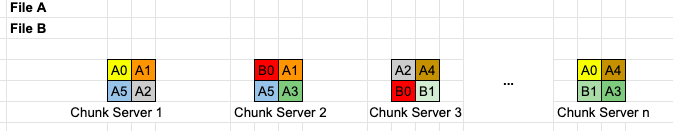



### Map Reduce -- Distributed file system

* Chunks are (16-64 MB) replicated across chunk servers (compute nodes)
  * Typically 3 replicates per chunk
  * No two chunks are on the same machine
  * preferably across node racks
* Catalogue of where each chunk is stored on a master nodes

### Word Counting: the Map Reduce Hello World

* Counting the number of words in a large document
* Solution is trivial is resulting counts fit in RAM
 * Read the file line by line
 * Use `dict` to store word counts 
* Still does not resolve the issue disk IO


### Map Reduce -- Word Counting - Cont'd

* Counting the number of words in a large document
  * K-mers in DNA sequence
* Counts do not fit in RAM. Therefore, we need multiple machines
* The primary cluster node knows where each chunk is hosted
* Each node is responsible for `mapping` words to an initial value
* Select nodes are responsible for `reducing` the initial values to totals.


![](https://www.dropbox.com/s/jwop5elec8trs5m/map_recude_words_example.png?dl=1)

### Map Reduce Diagram
![](https://www.dropbox.com/s/a9hc8po6me1dul3/map_reduce_simple.png?dl=1)

### Map Reduce Diagram: distributed

![](https://www.dropbox.com/s/1hrgg28sa720bhg/map_reduce_distributed.png?dl=1)


### Map-Reduce Framework

* The framework can simplify the computation considerably
* Manages fault tolerance
  * System can detect failed nodes and assign tasks to another compute node that hosts the data
* Minimizes data transfer by bringing computation to the data
  * Intermediate results of the map and reduce are stored on local FS (not distributed FS)
* Simplifies the development of distributed programs
  * Programs only need to write map-reduce functions
  * Paradigm cannot solve all types of problems but is useful for a plethora of big data mining tasks


### Map Reduce Framework Roles

* Partitioning the data and keeping track of chunk locations
* Scheduling the program's execution across a set of nodes
* Monitoring execution
* Performing the group by keys
* Managing required intermachine communication
* Handling node failures



### Role of Master Node

* Keeps track of the status of the task
  * idle, in progress, or completed
* Idle tasks are scheduled as workers become available
* When a map task completes it sends the master the location of its R intermediate files
  * Each of the R intermediate files is associated with the reducer task
  * The master pushes info to reducers
  * Reduced do not start computaiton (or file copies) until all map tasks are completed
* Master pings workers to detect compute node failures
  * Resets to idle all map tasks that ran on that compute node
  * Resets to idle in progress reduce tasks on the compute node

### Map Reduce Refinements - 1

* Save on the network overhead by running intermediate combine operations on each machine
  * In many instances, combiner can be a reducer operations
      * Reduce operation is commutative and associative
 
![](https://www.dropbox.com/s/kqsqhjjk0v256sn/map_combine_reduce.png?dl=1)

### Map Reduce Refinements - 1 cont'd

* Reducing a list of values to a single number may not work with some algorithm
    * e.g.: for computing average or median
```
        avg(1,1,1,1,1,1,1,1,3) != `average(avg(1,1,1,1,1,1,1,1,1), avg(1,1,1))`
```
        
* Trick for computing average: 
    1. Combiner returns `<k1, (sum_k1_i, count_k1_i)>` for each compute node `i`
    2. Reducer computes `<k1, (sum_k1_1 + sum_k1_2+ ... + sum_k1_i)/(count_k1_1 + count_k1_2 +...+count_k1_i)`
    
* This won't work with median
  * Median needs all the data. At the reducer, we can combine data and compute median once

In [7]:
a =[1,1,1,1,1,1,1,1,3]
print(sum(a)/len(a))
b =[1,1,1,1,1,1,1]
c =[1,3]

print((sum(b)/len(b) + sum(c)/len(c)) / 2)

1.2222222222222223
1.5


### Map Reduce Refinements - 2

* System uses a default partition function: `hash(key) mod R`
    * Generates a value $\in It is possible that the above function results in an unbalanced load where a small subset of nodes receives a large number of keys[0, R-1]$ representing the reducer that key will be assigned to.

* In some instances, it may help to have a different scheme
  * Logical reasons: 
    * you need all tweets from the same language assigned to the same machine
       * language-specific task on each machine.
       * `hash(language) mod R`
  * Reasons related to logistics:
    * The function above may yield an unbalanced load where more keys are assigned to a small subset of nodes

### Open Source Map-Reduce Implementations

* Hadoop: 
  * Open source implementation in Java
  * Uses the Hadoop Distributed File System (HDFS)
  * Files are stored as AVRO files
    * Row-based format makes it easy to chunk the files
  * Available on most cloud services platforms
    * [Amazon Elastic Map Reduce (EMR) services](https://aws.amazon.com/emr/features/hadoop/)
    * Google [Dataproc](https://cloud.google.com/dataproc), the managed Spark and Hadoop service 
    * Microsoft Azure [HDInsight](https://azure.microsoft.com/en-us/services/hdinsight/)
   


### Open Source Map-Reduce Implementations

* Hive and Pig
  * Apache SQL-Like abstraction on top of map-reduce
    * Very common use cases of Hadoop 
    * No need to implement `select`, `join`, `filter`, `agg` like operations.
  * Pig uses its own language (pig-Latin) for writing scripts
  * Hive uses SQL-like language for interactive queries or report generation
  * Hive and Pig are also available through cloud services providers
  
* Note that cloud providers have a computation (CPU time) cost, disk storage cost, and file transfer cost.

### Example Comparing Genomes
* Total of 5000 genomes
* Each genome is stored in its own file (~ 1MB per file)
  genome_id (g1, g2, ..., g5000), genome_sequence(s1, s2, ..., s5000)
  * File are relicated for redundancy
* We would like to compute all pairwise comparison using Hadoop


### Example Comparing Genomes - Solution 1

1. map oprations

  * map 1 

`<key=(gi, gj)  value= si >` where $i \ne j$
and therefore
`<key=(gj, gi)  value= sj>` 



  * Hadoop takes care of running the mapper where the data is located.


2. combine (automatic; does not need to be manually implemented )
`<key=(gi, gj), value= [si, sj]>`



3. reduce by comparing [si, sj]


  
* What is the problem with such an implementation?


### Example Comparing Genomes - Solution 1 and Data Transfer 

* There are 5000 genomes
* Each genome is compared against 4999 genomes to reduce to a unique comparison
* In the worst-case scenario, 24,995,000 of ~1 MB files
  * 23TB of data is transferred 
  * Requires ~6 Hours on 10GB connect 
  * Requires 2 days and 8 hours on 1GB Connect


### Example Comparing Genomes - Solution 2

* Split data by group of 100 genomes instead
* Each genome is in one and only one group i (ri) of the 50 resulting groups

* Map operation: for each genome, produce 49 pairs 
  * <key=(ri, rj)  value= gi> where gi in ri
  * <key=(ri, rj)  value= gj> where gj in rj
  

  * Since each group contains 100 genomes, the list will consist of 200 genomes 

* group by: group all all elements that have the same key

* Reduce operation:  compute all pairs within a list



### Example

```
r1 = 1, 2, 3
g2 = 4, 5, 6
g3 = 7, 8, 9 
```

##### map
```
<k(g1, g2), v = 1>, <k(g1, g3), v = 1>, <k(g1, g2), v = 2>, 
<k(g1, g3), v = 2>, <k(g1, g2), v = 3>, <k(g1, g3), v = 3>,
<k(g1, g2), v = 4>, <k(g2, g3), v = 4>, <k(g1, g2), v = 5>, 
<k(g2, g3), v = 5>, <k(g1, g2), v = 6>, <k(g2, g3), v = 6>,
<k(g1, g3), v = 7>, <k(g2, g3), v = 7>, <k(g1, g3), v = 8>,
<k(g2, g3), v = 8>, <k(g1, g3), v = 9>, <k(g2, g3), v = 9>
```
##### Combine
```
<k(g1, g2), val=[1,2,3,4,5,6]>
<k(g1, g3), val=[1,2,3,7,8,9]>
<k(g2, g3), val=[4,5,6,7,8,9]>
```


### Example Comparing Genomes - Refinement

* Previous reduce operations computed the same pairs across multiple reducers.
 
* We can constrain conditions where each is computed.
  * if i == j+1, compute pairs between elements in the first half of the list
  * if j is max group size, compute pairs between elements of the second half of the list.
